# Case Study Results for Pulse Physiology Engine

In this note, we include results of our case study assessing the accuracy of Pulse Physiology Engine using MIMIC as the observational dataset.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import os


In [83]:
column_renaming = {
    'Albumin': 'Albumin',
    'paCO2': 'paCO$_2$',
    'paO2': 'paO$_2$',
    'HCO3': 'HCO$_3$',
    'Arterial_pH': 'Arterial_pH',
    'Arterial_lactate': 'Lactate Blood Concentration',
    'Calcium': 'Calcium',
    'Chloride': 'Chloride',
    'Creatinine': 'Creatinine',
    'DiaBP': 'DiaBP',
    'SysBP': 'SysBP',
    'Glucose': 'Glucose',
    'MeanBP': 'MeanBP',
    'Potassium': 'Potassium',
    'RR': 'RR',
    'Temp_C': 'Temp',
    'Sodium': 'Sodium',
    'WBC_count': 'White Blood Cell Count',
    'HR': 'HR'
}

In [3]:
column_names_dict = {
    'Albumin': 'Albumin Blood Concentration',
    'paCO2': 'Arterial $CO_2$ Pressure',
    'paO2': 'Arterial $O_2$ Pressure',
    'HCO3': 'Bicarbonate Blood Concentration',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration',
    'Calcium': 'Calcium Blood Concentration',
    'Chloride': 'Chloride Blood Concentration',
    'Creatinine': 'Creatinine Blood Concentration',
    'DiaBP': 'Diastolic Arterial Pressure',
    'SysBP': 'Systolic Arterial Pressure',
    'Glucose': 'Glucose Blood Concentration',
    'MeanBP': 'Mean Arterial Pressure',
    'Potassium': 'Potassium Blood Concentration',
    'RR': 'Respiration Rate',
    'Temp_C': 'Skin Temperature',
    'Sodium': 'Sodium Blood Concentration',
    'WBC_count': 'White Blood Cell Count',
    'HR': 'Heart Rate'
}

# Hypothesis Rejections

### Reverse Percentile Results

In [4]:
from statsmodels.stats.multitest import multipletests

# Directory containing Reverse percentile results
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/revperc/"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals_revperc = pd.DataFrame()
pruned_hyps = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
        p_values_pruned = pd.read_csv(f"{hyp_test_dir}/pruned_hyps_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[p_values['t']>0]
            p_values['col'] = col
            p_values_pruned['col'] = col
            p_vals_revperc = pd.concat([p_vals_revperc, p_values], axis=0)
            pruned_hyps = pd.concat([pruned_hyps, p_values_pruned], axis=0)
p_vals_revperc['rejected_bonf_lb'] = p_vals_revperc['p_lb']<0.05/4/len(p_vals_revperc)
p_vals_revperc['rejected_bonf_ub'] = p_vals_revperc['p_ub']<0.05/4/len(p_vals_revperc)
p_vals_revperc['rejected_holms_lb'] = multipletests(p_vals_revperc['p_lb'], alpha=0.05/4, method='fdr_by')[0]
p_vals_revperc['rejected_holms_ub'] = multipletests(p_vals_revperc['p_ub'], alpha=0.05/4, method='fdr_by')[0]
p_vals_revperc['p_lb_fdr_bh'] = multipletests(p_vals_revperc['p_lb'], alpha=0.05/4, method='fdr_bh')[1]
p_vals_revperc['p_ub_fdr_bh'] = multipletests(p_vals_revperc['p_ub'], alpha=0.05/4, method='fdr_bh')[1]
p_vals_revperc['p_lb_fdr_by'] = multipletests(p_vals_revperc['p_lb'], alpha=0.05/4, method='fdr_by')[1]
p_vals_revperc['p_ub_fdr_by'] = multipletests(p_vals_revperc['p_ub'], alpha=0.05/4, method='fdr_by')[1]

for col in tqdm(column_names_dict):
    p_values = p_vals_revperc.loc[p_vals_revperc['col']==col]
    if len(p_values)>0:
        p_values = p_vals_revperc.loc[p_vals_revperc['col']==col]
        rej_hyps = p_values[(p_values['rejected_holms_lb']) | (p_values['rejected_holms_ub'])]
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)


results_bootstrapping_revperc = pd.DataFrame(data)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 984.04it/s]


### Percentile Results

In [46]:
from statsmodels.stats.multitest import multipletests

# Directory containing the percentile bootstrap results
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/perc/"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals_perc = pd.DataFrame()
pruned_hyps = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
        p_values_pruned = pd.read_csv(f"{hyp_test_dir}/pruned_hyps_{col}_hoeffFalse.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[p_values['t']>0]
            p_values['col'] = col
            p_values_pruned['col'] = col
            p_vals_perc = pd.concat([p_vals_perc, p_values], axis=0)
            pruned_hyps = pd.concat([pruned_hyps, p_values_pruned], axis=0)
p_vals_perc['rejected_bonf_lb'] = p_vals_perc['p_lb']<0.05/4/len(p_vals_perc)
p_vals_perc['rejected_bonf_ub'] = p_vals_perc['p_ub']<0.05/4/len(p_vals_perc)
p_vals_perc['rejected_holms_lb'] = multipletests(p_vals_perc['p_lb'], alpha=0.05/4, method='fdr_by')[0]
p_vals_perc['rejected_holms_ub'] = multipletests(p_vals_perc['p_ub'], alpha=0.05/4, method='fdr_by')[0]
p_vals_perc['p_lb_fdr_bh'] = multipletests(p_vals_perc['p_lb'], alpha=0.05/4, method='fdr_bh')[1]
p_vals_perc['p_ub_fdr_bh'] = multipletests(p_vals_perc['p_ub'], alpha=0.05/4, method='fdr_bh')[1]
p_vals_perc['p_lb_fdr_by'] = multipletests(p_vals_perc['p_lb'], alpha=0.05/4, method='fdr_by')[1]
p_vals_perc['p_ub_fdr_by'] = multipletests(p_vals_perc['p_ub'], alpha=0.05/4, method='fdr_by')[1]

for col in tqdm(column_names_dict):
    p_values = p_vals_perc.loc[p_vals_perc['col']==col]
    if len(p_values)>0:
        p_values = p_vals_perc.loc[p_vals_perc['col']==col]
        rej_hyps = p_values[(p_values['rejected_holms_lb']) | (p_values['rejected_holms_ub'])]
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)


results_bootstrapping_perc = pd.DataFrame(data)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 929.20it/s]


### Hoeffding's inequality

In [47]:

# Directory containing the hoeffding's inequality results
hyp_test_dir = "/data/localhost/not-backed-up/taufiq/HypothesisTesting/hyp_testing_new_pulse_data_2/hoeff/"

data = {'columns':[], 'total_hypotheses':[], 'rejected_hypotheses': [], 'percentage_of_rejected_hyp': []}
p_vals_hoeff = pd.DataFrame()
pruned_hyps = pd.DataFrame()
for col in tqdm(column_names_dict):
    if os.path.exists(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv"):
        p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col}_hoeffTrue.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval, 'yobs_values': eval, 'ysim_values': eval})
        p_values_pruned = pd.read_csv(f"{hyp_test_dir}/pruned_hyps_{col}_hoeffTrue.csv",  converters={'actions': eval, 'x_t': eval, 'Y_lb_mean': eval, 'Y_ub_mean': eval, 'Sim_exp_y': eval})
        if len(p_values)>0:
            p_values = p_values.loc[(p_values['t']>0)]
            p_values['col'] = col
            p_values_pruned['col'] = col
            p_vals_hoeff = pd.concat([p_vals_hoeff, p_values], axis=0)
            pruned_hyps = pd.concat([pruned_hyps, p_values_pruned], axis=0)
p_vals_hoeff['rejected_bonf_lb'] = p_vals_hoeff['p_lb']<0.05/4/len(p_vals_hoeff)
p_vals_hoeff['rejected_bonf_ub'] = p_vals_hoeff['p_ub']<0.05/4/len(p_vals_hoeff)
p_vals_hoeff['rejected_holms_lb'] = multipletests(p_vals_hoeff['p_lb'], alpha=0.05/4, method='fdr_bh')[0]
p_vals_hoeff['rejected_holms_ub'] = multipletests(p_vals_hoeff['p_ub'], alpha=0.05/4, method='fdr_bh')[0]
p_vals_hoeff['p_lb_fdr_bh'] = multipletests(p_vals_hoeff['p_lb'], alpha=0.05/4, method='fdr_bh')[1]
p_vals_hoeff['p_ub_fdr_bh'] = multipletests(p_vals_hoeff['p_ub'], alpha=0.05/4, method='fdr_bh')[1]
p_vals_hoeff['p_lb_fdr_by'] = multipletests(p_vals_hoeff['p_lb'], alpha=0.05/4, method='fdr_by')[1]
p_vals_hoeff['p_ub_fdr_by'] = multipletests(p_vals_hoeff['p_ub'], alpha=0.05/4, method='fdr_by')[1]
        
for col in tqdm(column_names_dict):
    p_values = p_vals_hoeff.loc[p_vals_hoeff['col']==col]
    if len(p_values)>0:
        p_values = p_vals_hoeff.loc[p_vals_hoeff['col']==col]
        rej_hyps = p_values[(p_values['rejected_holms_lb']) | (p_values['rejected_holms_ub'])]
        data['columns'].append(col)
        data['total_hypotheses'].append(len(p_values))
        data['rejected_hypotheses'].append(len(rej_hyps))
        data['percentage_of_rejected_hyp'].append(len(rej_hyps)/len(p_values)*100)

results_hoeff = pd.DataFrame(data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 970.40it/s]


In [48]:
results_hoeff

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,35,3,8.571429
1,paO2,39,0,0.000000
2,HCO3,45,2,4.444444
3,Arterial_pH,40,0,0.000000
4,Calcium,44,5,11.363636
5,Chloride,47,24,51.063830
6,DiaBP,36,0,0.000000
7,SysBP,77,2,2.597403
8,Glucose,48,5,10.416667
9,MeanBP,46,0,0.000000


In [49]:
results_bootstrapping_perc

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,35,12,34.285714
1,paO2,39,3,7.692308
2,HCO3,45,7,15.555556
3,Arterial_pH,40,0,0.000000
4,Calcium,44,44,100.000000
5,Chloride,47,47,100.000000
6,DiaBP,36,0,0.000000
7,SysBP,77,8,10.389610
8,Glucose,48,19,39.583333
9,MeanBP,46,3,6.521739


In [9]:
results_bootstrapping_revperc

,columns,total_hypotheses,rejected_hypotheses,percentage_of_rejected_hyp
0,paCO2,35,13,37.142857
1,paO2,39,4,10.256410
2,HCO3,45,8,17.777778
3,Arterial_pH,40,0,0.000000
4,Calcium,44,44,100.000000
5,Chloride,47,47,100.000000
6,DiaBP,36,0,0.000000
7,SysBP,77,8,10.389610
8,Glucose,48,19,39.583333
9,MeanBP,46,3,6.521739


## Rejections when using Hoeffding's inequality

In [105]:
combined_results = results_hoeff[['columns', 'total_hypotheses', 'rejected_hypotheses']].copy()
combined_results.rename(columns={'total_hypotheses': '# Hypotheses', 'rejected_hypotheses': '# Rejections (Bootstrap)'}, inplace=True)
combined_results['# Rejections']  = results_hoeff.loc[:, 'rejected_hypotheses']
combined_results['Outcomes'] = combined_results['columns'].apply(lambda x: column_names_dict[x] + ' ' + f'({column_renaming[x]})')
combined_results.sort_values(by='# Rejections', inplace=True, ascending=False)
combined_results['# Hypotheses'] *= 2
combined_results['order'] = np.arange(len(combined_results))
combined_results_hoeff = combined_results.copy()
print(combined_results[['Outcomes', '# Rejections', '# Hypotheses']].to_latex(index=False))


\begin{tabular}{lrr}
\toprule
                                 Outcomes &  \# Rejections &  \# Hypotheses \\
\midrule
  Chloride Blood Concentration (Chloride) &            24 &            94 \\
      Sodium Blood Concentration (Sodium) &            21 &            94 \\
Potassium Blood Concentration (Potassium) &            13 &            94 \\
                  Skin Temperature (Temp) &            10 &            86 \\
    Calcium Blood Concentration (Calcium) &             5 &            88 \\
    Glucose Blood Concentration (Glucose) &             5 &            96 \\
      Arterial \$CO\_2\$ Pressure (paCO\$\_2\$) &             3 &            70 \\
Bicarbonate Blood Concentration (HCO\$\_3\$) &             2 &            90 \\
       Systolic Arterial Pressure (SysBP) &             2 &           154 \\
        Arterial \$O\_2\$ Pressure (paO\$\_2\$) &             0 &            78 \\
                Arterial pH (Arterial\_pH) &             0 &            80 \\
      Diastolic Art

/tmp/ipykernel_918729/873760061.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(combined_results[['Outcomes', '# Rejections', '# Hypotheses']].to_latex(index=False))


## Rejections when using Reverse Percentile Bootstrap

In [107]:
combined_results = results_bootstrapping_revperc[['columns', 'total_hypotheses', 'rejected_hypotheses']].copy()
combined_results.rename(columns={'total_hypotheses': '# Hypotheses', 'rejected_hypotheses': '# Rejections (Bootstrap)'}, inplace=True)
combined_results['# Rejections']  = results_bootstrapping_revperc.loc[:, 'rejected_hypotheses']
combined_results['Outcomes'] = combined_results['columns'].apply(lambda x: column_names_dict[x] + ' ' + f'({column_renaming[x]})')
combined_results.sort_values(by='# Rejections', inplace=True)
combined_results['# Hypotheses'] *= 2
combined_results = pd.merge(left=combined_results, right=combined_results_hoeff[['Outcomes', 'order']], on=['Outcomes'])
combined_results.sort_values(by='order', inplace=True)
print(combined_results[['Outcomes', '# Rejections', '# Hypotheses']].to_latex(index=False))


\begin{tabular}{lrr}
\toprule
                                 Outcomes &  \# Rejections &  \# Hypotheses \\
\midrule
  Chloride Blood Concentration (Chloride) &            47 &            94 \\
      Sodium Blood Concentration (Sodium) &            46 &            94 \\
Potassium Blood Concentration (Potassium) &            33 &            94 \\
                  Skin Temperature (Temp) &            43 &            86 \\
    Calcium Blood Concentration (Calcium) &            44 &            88 \\
    Glucose Blood Concentration (Glucose) &            19 &            96 \\
      Arterial \$CO\_2\$ Pressure (paCO\$\_2\$) &            13 &            70 \\
Bicarbonate Blood Concentration (HCO\$\_3\$) &             8 &            90 \\
       Systolic Arterial Pressure (SysBP) &             8 &           154 \\
        Arterial \$O\_2\$ Pressure (paO\$\_2\$) &             4 &            78 \\
                Arterial pH (Arterial\_pH) &             0 &            80 \\
      Diastolic Art

/tmp/ipykernel_918729/1763480515.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(combined_results[['Outcomes', '# Rejections', '# Hypotheses']].to_latex(index=False))


## Reverse percentile p values

2023-01-16 13:05:59,648 [DEBUG] Assigning font /b'F1' = '/data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2023-01-16 13:05:59,664 [DEBUG] Assigning font /b'F2' = '/data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
2023-01-16 13:05:59,753 [DEBUG] Embedding font /data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
2023-01-16 13:05:59,753 [DEBUG] Writing TrueType font.
2023-01-16 13:05:59,763 [DEBUG] Embedding font /data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2023-01-16 13:05:59,763 [DEBUG] Writing TrueType font.


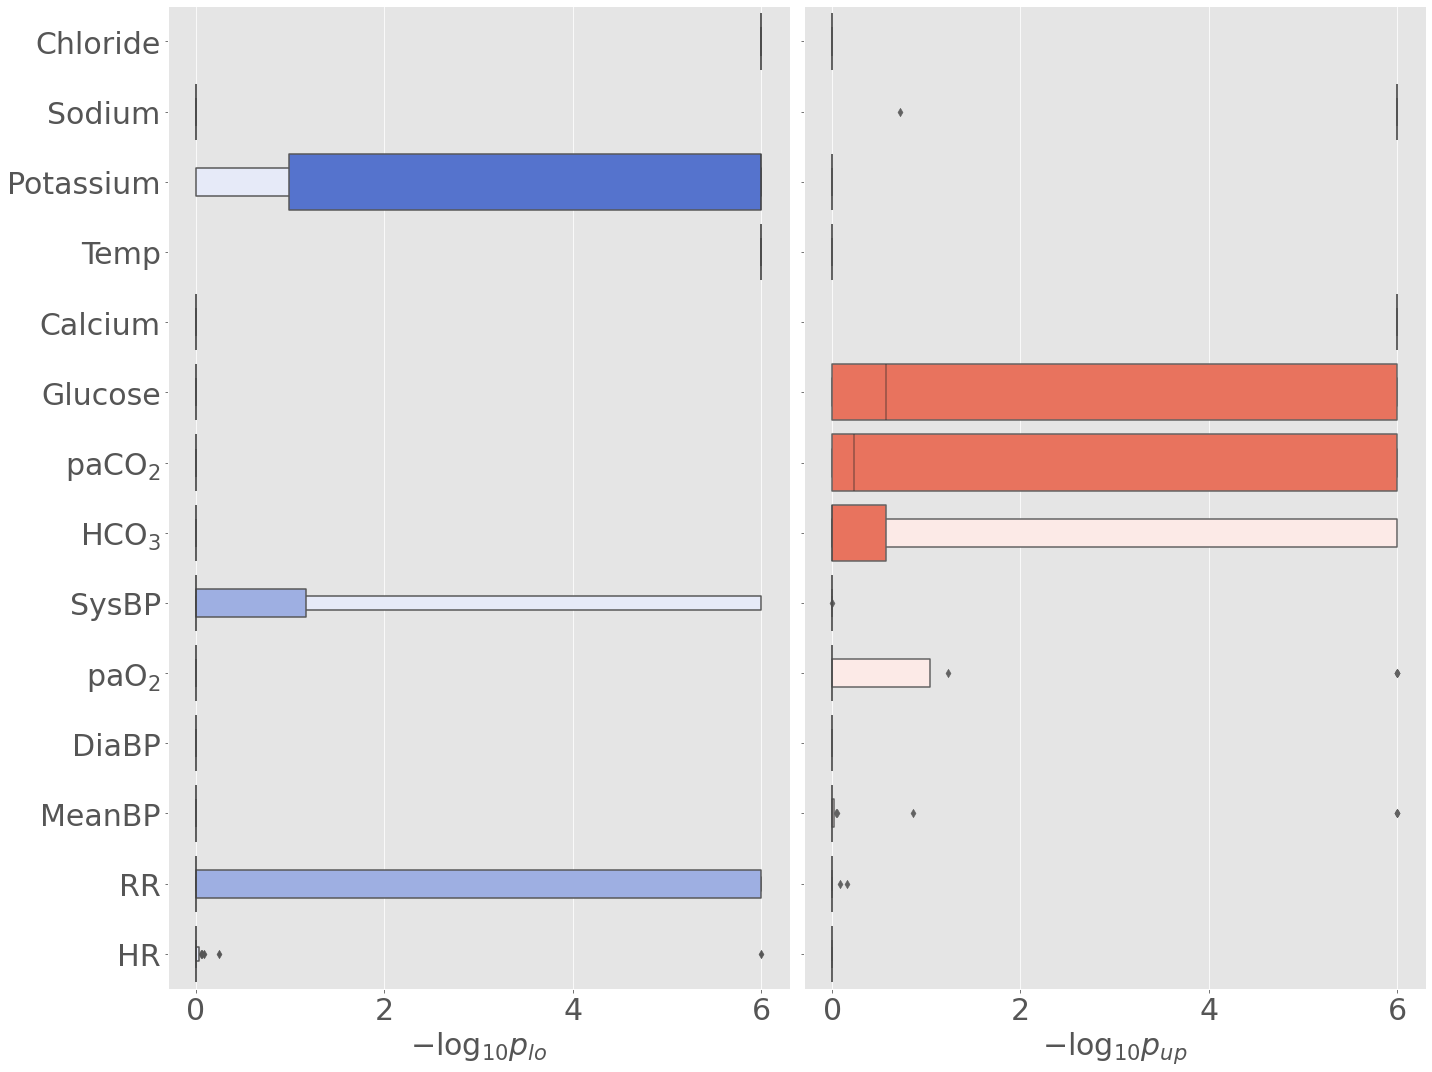

In [151]:
import seaborn as sns

outcomes = combined_results['columns'].unique()
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(20,15), sharey=True)

p_vals_revperc = p_vals_revperc[p_vals_revperc['col']!='Arterial_pH']

p_vals_revperc['Outcomes'] = p_vals_revperc['col'].apply(lambda x: column_renaming[x])
p_vals_revperc['order'] = p_vals_revperc['col'].apply(lambda x: list(outcomes).index(x))
p_vals_revperc['-log_p_lb'] = p_vals_revperc['p_lb'].apply(lambda x: -np.log10(min(x, 1)))
p_vals_revperc['-log_p_ub'] = p_vals_revperc['p_ub'].apply(lambda x: -np.log10(min(x, 1)))
p_vals_revperc.sort_values(by='order', inplace=True)
ax = sns.boxenplot(x='-log_p_lb', y='Outcomes', data=p_vals_revperc, ax=axs[0], color='royalblue' )
ax = sns.boxenplot(x='-log_p_ub', y='Outcomes', data=p_vals_revperc, ax=axs[1], color='tomato' )


axs[1].tick_params(axis='x', labelsize=30)
axs[0].set_ylabel('', fontsize=30)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('$-\log_{10}{p_{lo}}$', fontsize=30)
axs[1].set_xlabel('$-\log_{10}{p_{up}}$', fontsize=30)
axs[0].tick_params(axis='both', which='major', labelsize=30)
axs[0].tick_params(axis='both', which='minor', labelsize=30)
axs[1].tick_params(axis='both', which='major', labelsize=30)
axs[1].tick_params(axis='both', which='minor', labelsize=30)
plt.tight_layout()




## Hoeffding's p values

2023-01-16 13:02:44,037 [DEBUG] Assigning font /b'F1' = '/data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2023-01-16 13:02:44,057 [DEBUG] Assigning font /b'F2' = '/data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
2023-01-16 13:02:44,132 [DEBUG] Embedding font /data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
2023-01-16 13:02:44,132 [DEBUG] Writing TrueType font.
2023-01-16 13:02:44,142 [DEBUG] Embedding font /data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2023-01-16 13:02:44,142 [DEBUG] Writing TrueType font.


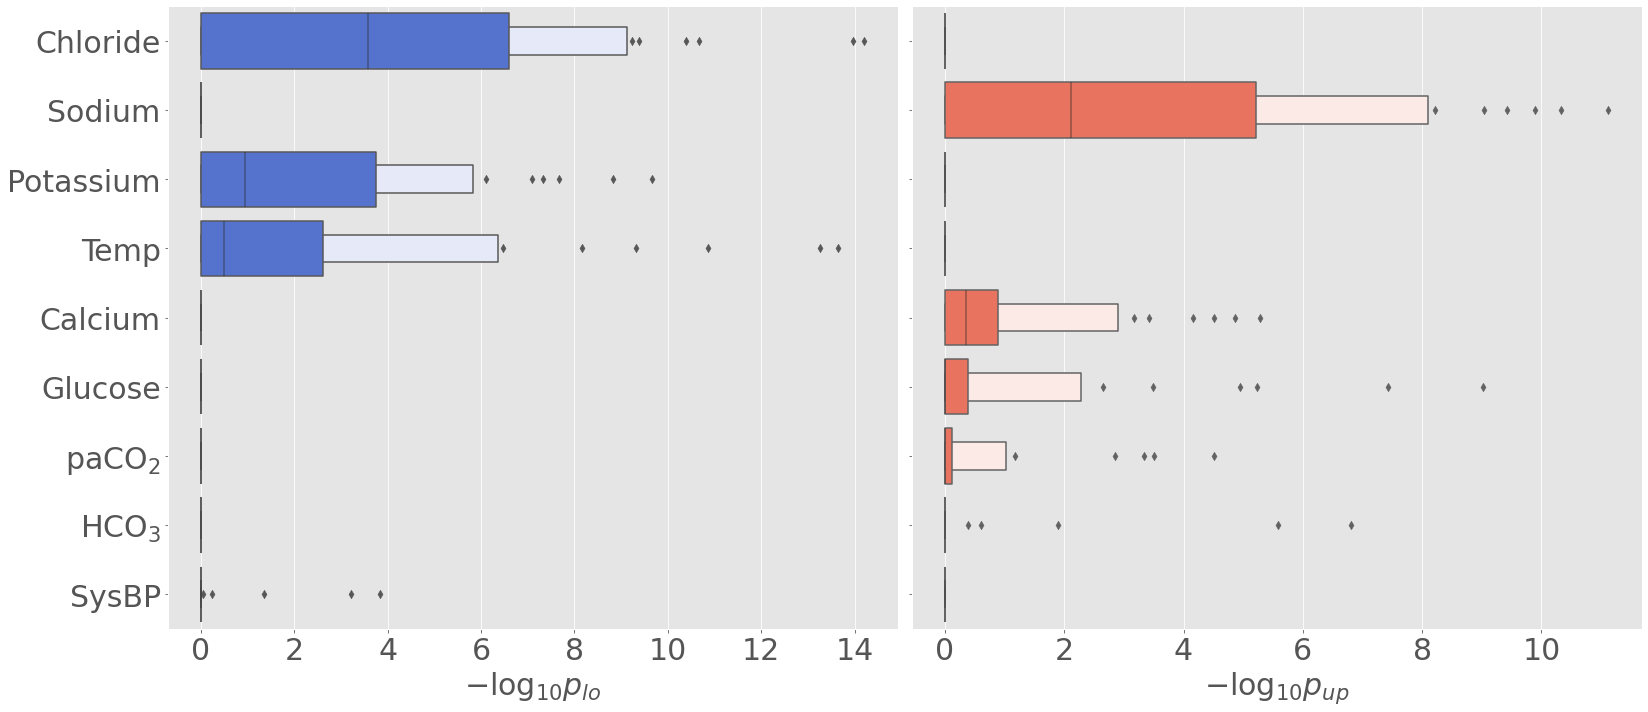

In [148]:
import seaborn as sns

outcomes = combined_results['columns'].unique()
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(23,10), sharey=True)

p_vals_hoeff = p_vals_hoeff[p_vals_hoeff['col']!='Arterial_pH']


p_vals_hoeff['Outcomes'] = p_vals_hoeff['col'].apply(lambda x: column_renaming[x])
p_vals_hoeff['order'] = p_vals_hoeff['col'].apply(lambda x: list(outcomes).index(x))
p_vals_hoeff['-log_p_lb'] = p_vals_hoeff['p_lb'].apply(lambda x: -np.log10(min(x, 1)))
p_vals_hoeff['-log_p_ub'] = p_vals_hoeff['p_ub'].apply(lambda x: -np.log10(min(x, 1)))
p_vals_hoeff.sort_values(by='order', inplace=True)
outcomes = list(p_vals_hoeff['Outcomes'].unique())[:9]
p_vals_hoeff_filtered = p_vals_hoeff[p_vals_hoeff['Outcomes'].isin(outcomes)]

ax = sns.boxenplot(x='-log_p_lb', y='Outcomes', data=p_vals_hoeff_filtered, ax=axs[0], color='royalblue' )
ax = sns.boxenplot(x='-log_p_ub', y='Outcomes', data=p_vals_hoeff_filtered, ax=axs[1], color='tomato' )


axs[1].tick_params(axis='x', labelsize=30)
axs[0].set_ylabel('', fontsize=30)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('$-\log_{10}{p_{lo}}$', fontsize=30)
axs[1].set_xlabel('$-\log_{10}{p_{up}}$', fontsize=30)
axs[0].tick_params(axis='both', which='major', labelsize=30)
axs[0].tick_params(axis='both', which='minor', labelsize=30)
axs[1].tick_params(axis='both', which='major', labelsize=30)
axs[1].tick_params(axis='both', which='minor', labelsize=30)
plt.tight_layout()



2023-01-16 13:05:16,616 [DEBUG] Assigning font /b'F1' = '/data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2023-01-16 13:05:16,631 [DEBUG] Assigning font /b'F2' = '/data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
2023-01-16 13:05:16,729 [DEBUG] Embedding font /data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
2023-01-16 13:05:16,730 [DEBUG] Writing TrueType font.
2023-01-16 13:05:16,739 [DEBUG] Embedding font /data/ziz/taufiq/myenv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2023-01-16 13:05:16,739 [DEBUG] Writing TrueType font.


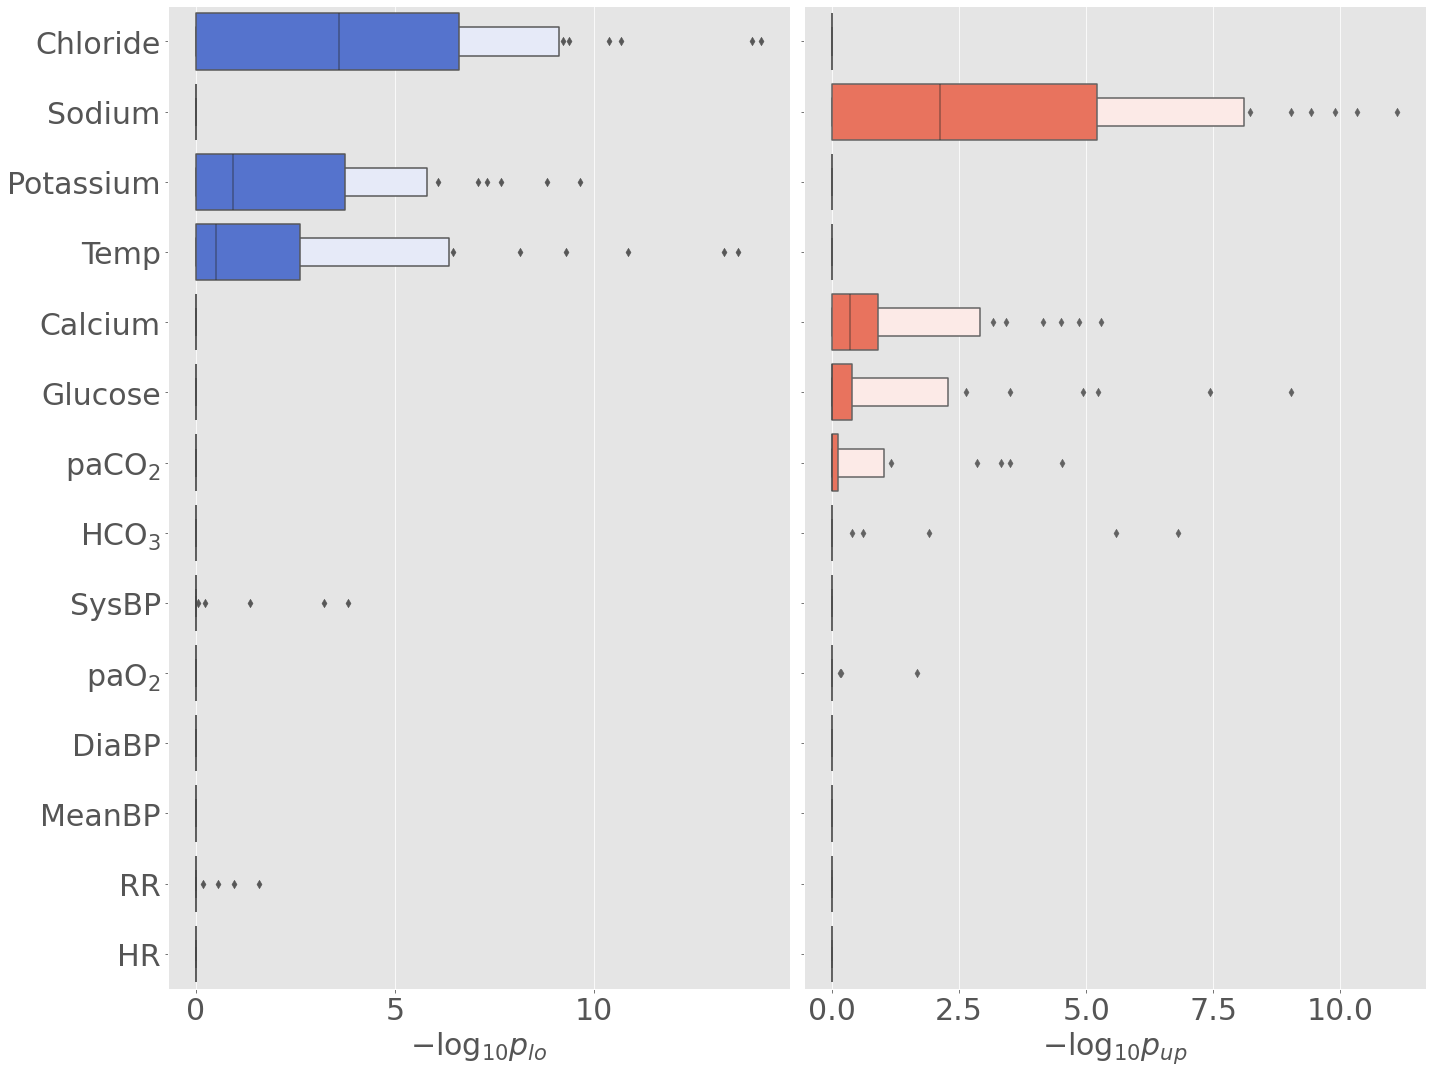

In [150]:
import seaborn as sns

outcomes = combined_results['columns'].unique()
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(20,15), sharey=True)

p_vals_hoeff = p_vals_hoeff[p_vals_hoeff['col']!='Arterial_pH']

p_vals_hoeff['Outcomes'] = p_vals_hoeff['col'].apply(lambda x: column_renaming[x])
p_vals_hoeff['order'] = p_vals_hoeff['col'].apply(lambda x: list(outcomes).index(x))
p_vals_hoeff['-log_p_lb'] = p_vals_hoeff['p_lb'].apply(lambda x: -np.log10(min(x, 1)))
p_vals_hoeff['-log_p_ub'] = p_vals_hoeff['p_ub'].apply(lambda x: -np.log10(min(x, 1)))
p_vals_hoeff.sort_values(by='order', inplace=True)
ax = sns.boxenplot(x='-log_p_lb', y='Outcomes', data=p_vals_hoeff, ax=axs[0], color='royalblue' )
ax = sns.boxenplot(x='-log_p_ub', y='Outcomes', data=p_vals_hoeff, ax=axs[1], color='tomato' )

axs[1].tick_params(axis='x', labelsize=30)
axs[0].set_ylabel('', fontsize=30)
axs[1].set_ylabel('', fontsize=16)
axs[0].set_xlabel('$-\log_{10}{p_{lo}}$', fontsize=30)
axs[1].set_xlabel('$-\log_{10}{p_{up}}$', fontsize=30)
axs[0].tick_params(axis='both', which='major', labelsize=30)
axs[0].tick_params(axis='both', which='minor', labelsize=30)
axs[1].tick_params(axis='both', which='major', labelsize=30)
axs[1].tick_params(axis='both', which='minor', labelsize=30)
plt.tight_layout()



## Histograms of $n$ and $\widehat{n}$

2023-01-16 09:03:22,249 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,261 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,287 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,305 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,323 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,342 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,360 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,380 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,398 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,416 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,435 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:22,453 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03

2023-01-16 09:03:23,840 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:23,852 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:23,864 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:23,876 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:23,960 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:23,970 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:23,979 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:23,988 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:23,997 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:24,006 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:24,016 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:24,025 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03

2023-01-16 09:03:25,211 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,224 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,236 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,248 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,260 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,272 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,284 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,296 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,387 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,398 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,410 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:25,422 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03

2023-01-16 09:03:26,602 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,611 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,621 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,630 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,640 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,649 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,660 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,669 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,679 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,689 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,702 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:26,714 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03

2023-01-16 09:03:27,818 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,827 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,836 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,845 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,855 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,864 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,874 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,883 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,893 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,902 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,911 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03:27,920 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 09:03

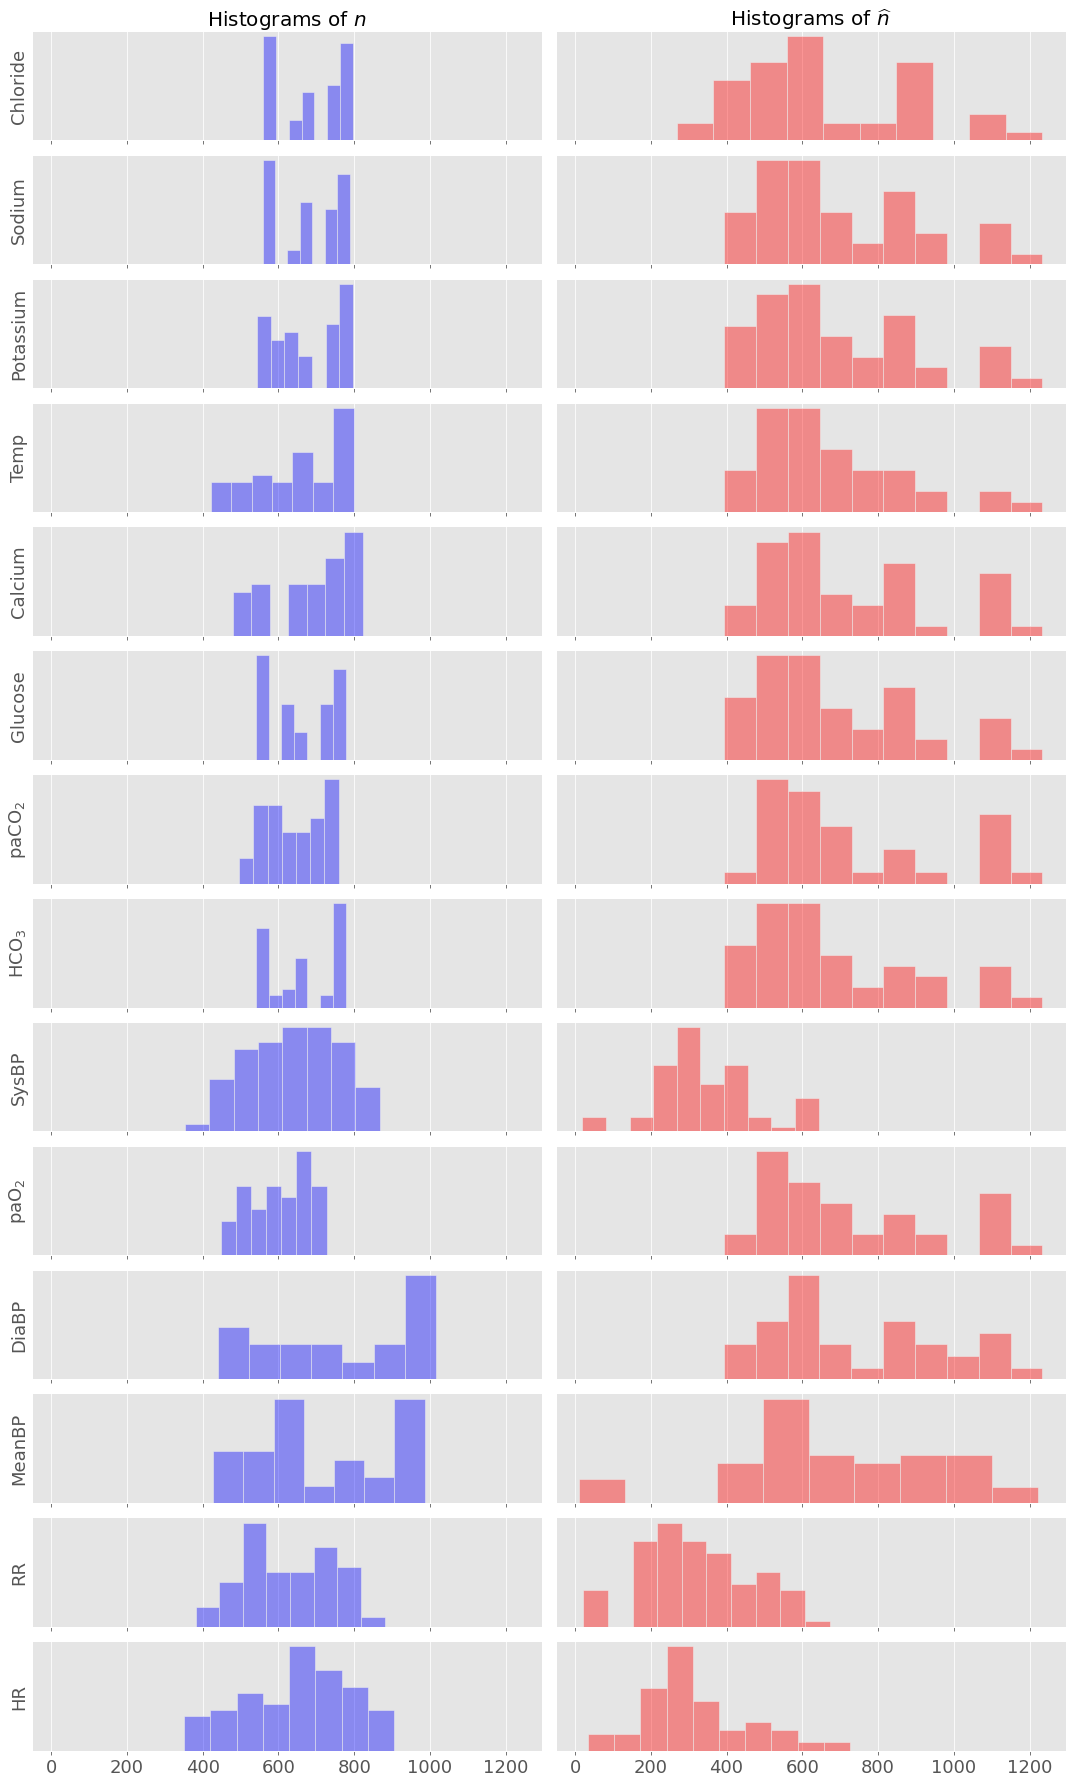

In [127]:
cols = p_vals_hoeff['col'].unique()
fig, axs = plt.subplots(len(cols), 2, figsize=(15,25), sharex=True)
axs[0][0].set_title('Histograms of $n$', fontsize=20)
axs[0][1].set_title('Histograms of $\widehat{n}$', fontsize=20)
for i in range(len(cols)):
    p_values = p_vals_hoeff[p_vals_hoeff['col']==cols[i]]
    sns.histplot(x='n_obs', data=p_values, ax=axs[i][0], color='blue', alpha=0.4, bins='auto')
    sns.histplot(x='n_sim', data=p_values, ax=axs[i][1], color='r', alpha=0.4, bins=10)
    axs[i][0].set_ylabel(column_renaming[cols[i]], rotation=90, position=(-10, 0), fontsize=18)
    axs[i][1].set_ylabel('')
    axs[i][0].set_yticks([])
    axs[i][1].set_yticks([])
    plt.tight_layout()
axs[i][0].set_xlabel('')
axs[i][1].set_xlabel('')
axs[i][1].tick_params(axis='both', which='major', labelsize=18)
axs[i][1].tick_params(axis='both', which='minor', labelsize=18)
axs[i][0].tick_params(axis='both', which='major', labelsize=18)
axs[i][0].tick_params(axis='both', which='minor', labelsize=18)



# Histograms of $\frac{\text{Length of Hoeffding's intervals}}{\text{Length of Bootstrapping intervals}}$

In [16]:
import sys
sys.path.append("../")
from GenerateHistograms import get_hoeffding_bounds

In [122]:
p_vals_combined = p_vals_revperc.copy()
p_vals_combined['ylb_int_hoeff'] = p_vals_combined.apply(lambda x: np.clip(get_hoeffding_bounds(0, x)[0], x['y_lo'], x['y_up'],), axis=1)
p_vals_combined['yub_int_hoeff'] = p_vals_combined.apply(lambda x: np.clip(get_hoeffding_bounds(0, x)[1], x['y_lo'], x['y_up'],), axis=1)
p_vals_combined['ysim_int_hoeff'] = p_vals_combined.apply(lambda x: np.clip(get_hoeffding_bounds(0, x)[2], x['y_lo'], x['y_up'],), axis=1)
p_vals_combined['len_int_hoeff_lo'] = p_vals_combined['ylb_int_hoeff'].apply(lambda x: x[1] - x[0])
p_vals_combined['len_int_hoeff_up'] = p_vals_combined['yub_int_hoeff'].apply(lambda x: x[1] - x[0])


p_vals_combined = p_vals_combined.rename(columns={'Y_lb_mean': 'Y_lb_mean_revperc',
                                          'Y_ub_mean': 'Y_ub_mean_revperc'}, inplace=False)

p_vals_combined = pd.merge(left=p_vals_combined, right=p_vals_hoeff, on=['gender', 'age', 'actions', 'x_t', 't', 'col'],)


In [123]:
p_vals_combined['lb_revperc'] = p_vals_combined['Y_lb_mean'].apply(lambda x: np.quantile(x, 0.025))
p_vals_combined['ub_revperc'] = p_vals_combined['Y_ub_mean'].apply(lambda x: np.quantile(x, 0.975))
p_vals_combined['ysim_lb_revperc'] = p_vals_combined['Sim_exp_y_x'].apply(lambda x: np.quantile(x, 0.025))
p_vals_combined['ysim_ub_revperc'] = p_vals_combined['Sim_exp_y_x'].apply(lambda x: np.quantile(x, 0.975))

p_vals_combined['len_int_revperc_lo'] = p_vals_combined['y_up_x'] - p_vals_combined['lb_revperc']
p_vals_combined['len_int_revperc_up'] = p_vals_combined['ub_revperc'] - p_vals_combined['y_lo_x']

p_vals_combined['Len_ratios_lo'] = p_vals_combined['len_int_revperc_lo']/p_vals_combined['len_int_hoeff_lo']
p_vals_combined['Len_ratios_up'] = p_vals_combined['len_int_revperc_up']/p_vals_combined['len_int_hoeff_up']



2023-01-16 08:40:47,674 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,695 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,731 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,752 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,773 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,794 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,815 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,837 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,858 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,879 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,900 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:47,921 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40

2023-01-16 08:40:49,398 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,411 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,423 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,436 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,524 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,535 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,546 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,557 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,568 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,578 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,589 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:49,600 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40

2023-01-16 08:40:50,873 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:50,885 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:50,898 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:50,910 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:50,923 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:50,935 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:50,948 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:50,960 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:51,051 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:51,061 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:51,071 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:51,082 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40

2023-01-16 08:40:52,311 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,321 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,332 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,342 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,353 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,363 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,374 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,384 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,395 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,405 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,421 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:52,434 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40

2023-01-16 08:40:53,671 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,681 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,691 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,702 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,712 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,722 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,732 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,743 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,753 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,763 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,773 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:53,783 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40

2023-01-16 08:40:55,269 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,283 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,333 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,345 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,357 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,369 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,380 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,392 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,404 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,416 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,427 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:55,439 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40

2023-01-16 08:40:56,740 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:56,754 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:56,768 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:56,783 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:56,797 [DEBUG] top of Axes not in the figure, so title not moved
2023-01-16 08:40:56,811 [DEBUG] top of Axes not in the figure, so title not moved


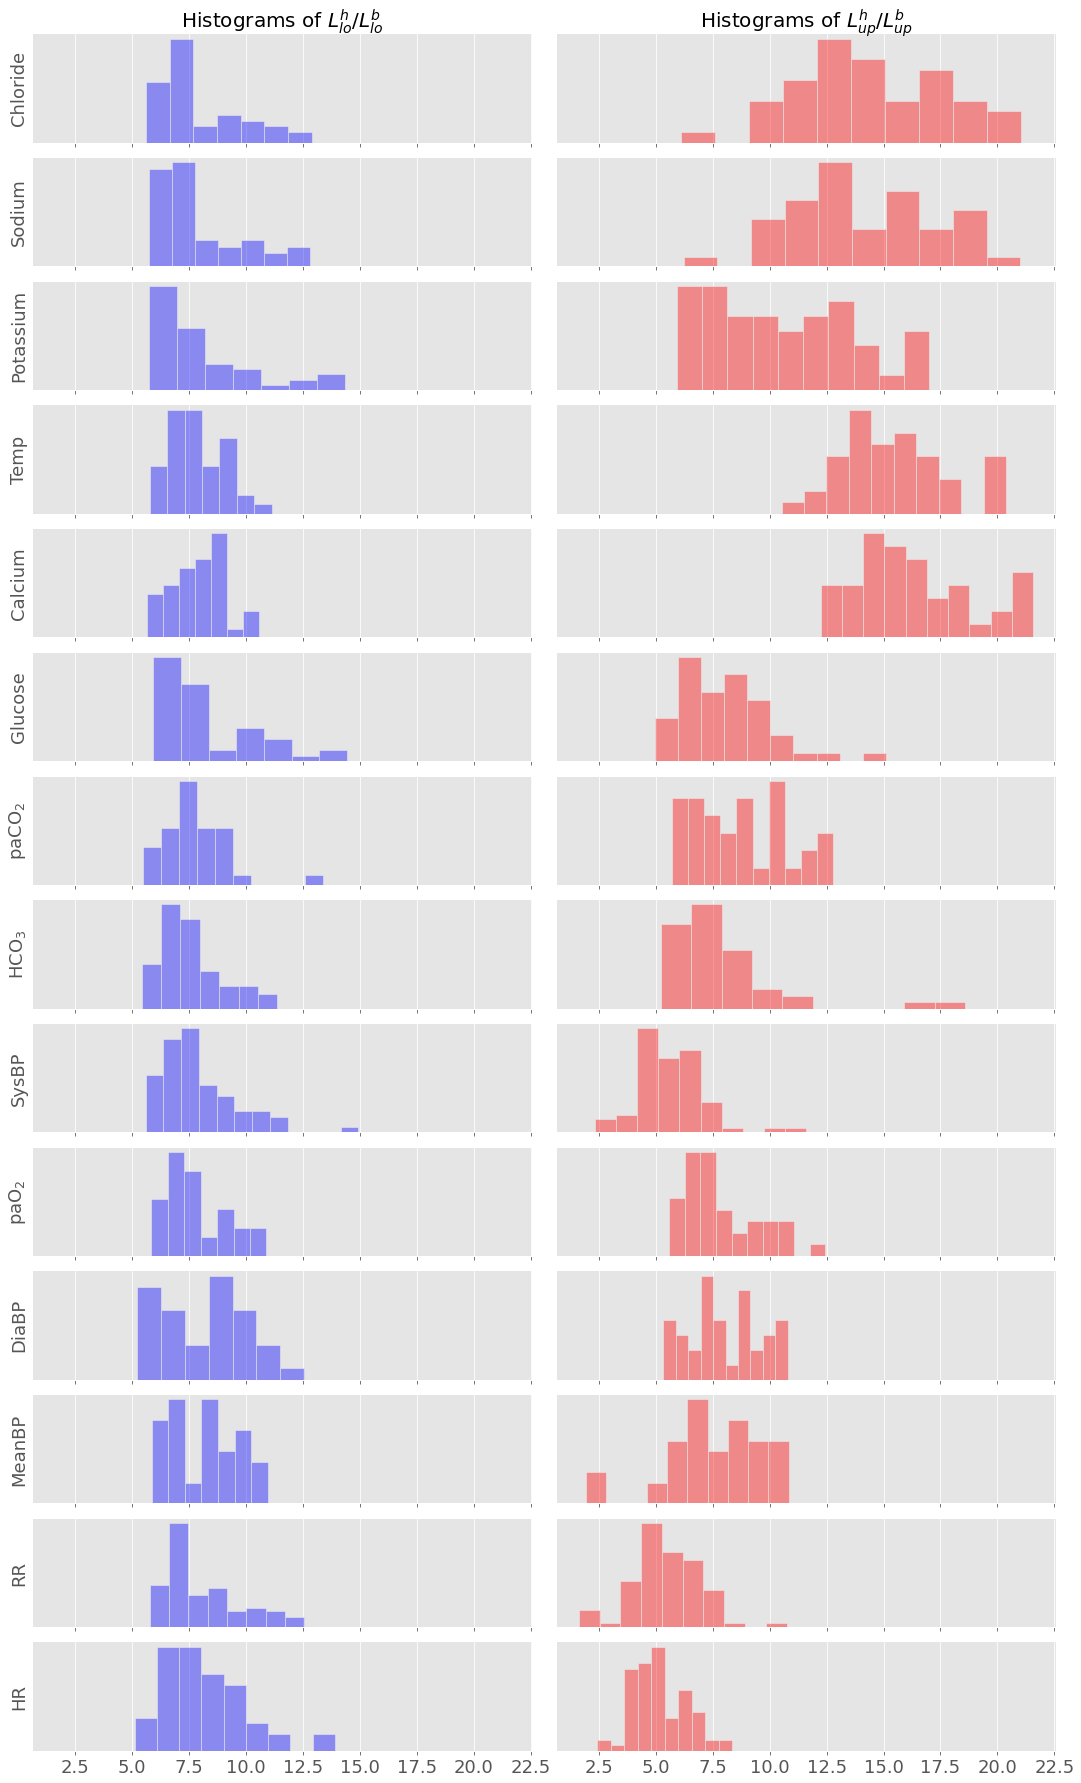

In [124]:
cols = p_vals_combined['col'].unique()
fig, axs = plt.subplots(len(cols), 2, figsize=(15,25), sharex=True)
axs[0][0].set_title("Histograms of $L_{lo}^{h}/L_{lo}^{b}$", fontsize=20)
axs[0][1].set_title('Histograms of $L_{up}^{h}/L_{up}^{b}$', fontsize=20)
for i in range(len(cols)):
    p_values = p_vals_combined[p_vals_combined['col']==cols[i]]
    sns.histplot(x='Len_ratios_lo', data=p_values, ax=axs[i][0], color='blue', alpha=0.4, bins='auto')
    sns.histplot(x='Len_ratios_up', data=p_values, ax=axs[i][1], color='r', alpha=0.4, bins=10)
    axs[i][0].set_ylabel(column_renaming[cols[i]], rotation=90, position=(-10, 0), fontsize=18)
    axs[i][1].set_ylabel('')
    axs[i][0].set_yticks([])
    axs[i][1].set_yticks([])
    plt.tight_layout()
axs[i][0].set_xlabel('')
axs[i][1].set_xlabel('')
axs[i][1].tick_params(axis='both', which='major', labelsize=18)
axs[i][1].tick_params(axis='both', which='minor', labelsize=18)
axs[i][0].tick_params(axis='both', which='major', labelsize=18)
axs[i][0].tick_params(axis='both', which='minor', labelsize=18)

